# Problem 3: Two Variational Autoencoders
## 3.1 Vanilla VAE

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

class VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super().__init__()

        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)   # mu
        self.fc22 = nn.Linear(n_hid, z_dim)   # logvar
        self.fc3 = nn.Linear(z_dim, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x, c=None):
        """Encoder forward pass: x -> (mu, logvar).  c is ignored for vanilla VAE."""
        h = F.relu(self.fc1(x))
        mu = self.fc21(h)
        logvar = self.fc22(h)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon * stdev, with epsilon ~ N(0, I)."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z, c=None):
        """Decoder forward pass: z -> reconstruction of x.  c is ignored."""
        h = F.relu(self.fc3(z))
        # FashionMNIST pixels are in [0,1], so we use sigmoid at the output
        x_recon = torch.sigmoid(self.fc4(h))
        return x_recon
        
    def forward(self, x, c=None):
        # x: (batch_size, 784)
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [2]:
n_in = 784
n_hid = 400
z_dim = 20
learning_rate = 1e-3
batch_size = 128
num_epochs = 20

# ------------------------
# Data: FashionMNIST + 20% validation split
# ------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
])

full_train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True,
)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ------------------------
# Loss: reconstruction + KL
# ------------------------
def vae_loss(recon_x, x, mu, logvar):
    # flatten to (batch, 784)
    x = x.view(x.size(0), -1)
    recon_x = recon_x.view(x.size(0), -1)

    # Binary cross-entropy reconstruction loss (sum over pixels)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction="sum")

    # KL divergence between q(z|x) and N(0,I)
    # 0.5 * sum(mu^2 + sigma^2 - log(sigma^2) - 1)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # average per data point (optional)
    return (recon_loss + kld) / x.size(0)

# ------------------------
# Training loop
# ------------------------
model = VAE(n_in, n_hid, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    for x, labels in train_loader:
        x = x.to(device).view(-1, n_in)  # flatten
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)   # c is ignored
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, labels in val_loader:
            x = x.to(device).view(-1, n_in)
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar)
            val_loss += loss.item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:03d} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

torch.save(model.state_dict(), "vae_fashionmnist.pt")
print("Saved model weights to vae_fashionmnist.pt")

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 253kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.84MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.9MB/s]


Epoch 001 | train loss: 290.3483 | val loss: 264.7819
Epoch 002 | train loss: 258.9247 | val loss: 256.3403
Epoch 003 | train loss: 252.8323 | val loss: 251.4031
Epoch 004 | train loss: 249.5057 | val loss: 248.9714
Epoch 005 | train loss: 247.5360 | val loss: 247.2198
Epoch 006 | train loss: 246.2268 | val loss: 246.2897
Epoch 007 | train loss: 245.2569 | val loss: 245.2917
Epoch 008 | train loss: 244.5115 | val loss: 245.0276
Epoch 009 | train loss: 243.9698 | val loss: 244.3799
Epoch 010 | train loss: 243.5142 | val loss: 244.1185
Epoch 011 | train loss: 243.1693 | val loss: 243.6222
Epoch 012 | train loss: 242.8897 | val loss: 243.4241
Epoch 013 | train loss: 242.5679 | val loss: 243.2843
Epoch 014 | train loss: 242.3468 | val loss: 243.0216
Epoch 015 | train loss: 242.0210 | val loss: 242.7011
Epoch 016 | train loss: 241.8006 | val loss: 242.5665
Epoch 017 | train loss: 241.6295 | val loss: 242.2854
Epoch 018 | train loss: 241.4636 | val loss: 242.1922
Epoch 019 | train loss: 241.

## 3.2 C-VAE

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

class CVAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim, n_classes):
        super().__init__()
        self.n_in = n_in
        self.n_classes = n_classes

        # encoder: [x, one_hot(c)] -> h -> mu, logvar
        self.fc1 = nn.Linear(n_in + n_classes, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)

        # decoder: [z, one_hot(c)] -> h -> x_hat
        self.fc3 = nn.Linear(z_dim + n_classes, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x, c):
        """
        Encoder forward pass.
        x: (B, 784)
        c: (B,) long labels
        """
        one_hot = F.one_hot(c, num_classes=self.n_classes).float()
        inp = torch.cat([x, one_hot], dim=1)
        h = F.relu(self.fc1(inp))
        mu = self.fc21(h)
        logvar = self.fc22(h)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon * stdev."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z, c):
        """
        Decoder forward pass.
        z: (B, z_dim)
        c: (B,) long labels
        """
        one_hot = F.one_hot(c, num_classes=self.n_classes).float()
        inp = torch.cat([z, one_hot], dim=1)
        h = F.relu(self.fc3(inp))
        x_recon = torch.sigmoid(self.fc4(h))  # outputs in [0,1]
        return x_recon
        
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [4]:
n_in = 784
n_hid = 400
z_dim = 20
n_classes = 10
learning_rate = 1e-3
batch_size = 128
num_epochs = 20

transform = transforms.Compose([
    transforms.ToTensor(),
])

full_train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True,
)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def vae_loss(recon_x, x, mu, logvar):
    x = x.view(x.size(0), -1)
    recon_x = recon_x.view(x.size(0), -1)

    recon_loss = F.binary_cross_entropy(recon_x, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kld) / x.size(0)


In [5]:
model = CVAE(n_in, n_hid, z_dim, n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    for x, labels in train_loader:
        x = x.to(device).view(-1, n_in)
        labels = labels.to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x, labels)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, labels in val_loader:
            x = x.to(device).view(-1, n_in)
            labels = labels.to(device)
            recon_x, mu, logvar = model(x, labels)
            loss = vae_loss(recon_x, x, mu, logvar)
            val_loss += loss.item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:03d} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

# ------------------------
# Save C-VAE weights for later use (required by 3.2)
# ------------------------
torch.save(model.state_dict(), "cvae_fashionmnist.pt")
print("Saved model weights to cvae_fashionmnist.pt")

Epoch 001 | train loss: 290.3016 | val loss: 262.4978
Epoch 002 | train loss: 257.8125 | val loss: 252.6125
Epoch 003 | train loss: 250.9448 | val loss: 247.8219
Epoch 004 | train loss: 247.2942 | val loss: 244.8680
Epoch 005 | train loss: 245.1321 | val loss: 243.2835
Epoch 006 | train loss: 243.6201 | val loss: 242.0301
Epoch 007 | train loss: 242.4977 | val loss: 241.1477
Epoch 008 | train loss: 241.6783 | val loss: 240.3919
Epoch 009 | train loss: 241.0254 | val loss: 239.9772
Epoch 010 | train loss: 240.4261 | val loss: 239.5868
Epoch 011 | train loss: 239.8918 | val loss: 239.0188
Epoch 012 | train loss: 239.5168 | val loss: 238.7477
Epoch 013 | train loss: 239.0728 | val loss: 238.2041
Epoch 014 | train loss: 238.8118 | val loss: 238.0087
Epoch 015 | train loss: 238.4650 | val loss: 237.5201
Epoch 016 | train loss: 238.2286 | val loss: 237.4653
Epoch 017 | train loss: 238.0273 | val loss: 237.4298
Epoch 018 | train loss: 237.8721 | val loss: 237.0821
Epoch 019 | train loss: 237.

## 3.3 Manifold Comparison

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

n_in = 784
n_hid = 400
z_dim = 20
n_classes = 10

# ---------------------------------------------------
# Load test set
# ---------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True,
)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# ---------------------------------------------------
# Load trained models
# ---------------------------------------------------
vae = VAE(n_in, n_hid, z_dim).to(device)
vae.load_state_dict(torch.load("vae_fashionmnist.pt", map_location=device))
vae.eval()

cvae = CVAE(n_in, n_hid, z_dim, n_classes).to(device)
cvae.load_state_dict(torch.load("cvae_fashionmnist.pt", map_location=device))
cvae.eval()

# ---------------------------------------------------
# Collect mu for all test samples
# ---------------------------------------------------
all_mu_vae = []
all_mu_cvae = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device).view(-1, n_in)
        y = y.to(device)

        # VAE
        mu_vae, logvar_vae = vae.encode(x)              # c not used
        # C-VAE
        mu_cvae, logvar_cvae = cvae.encode(x, y)

        all_mu_vae.append(mu_vae.cpu())
        all_mu_cvae.append(mu_cvae.cpu())
        all_labels.append(y.cpu())

all_mu_vae = torch.cat(all_mu_vae, dim=0).numpy()
all_mu_cvae = torch.cat(all_mu_cvae, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

print("Shapes:",
      all_mu_vae.shape, all_mu_cvae.shape, all_labels.shape)

Shapes: (10000, 20) (10000, 20) (10000,)


/var/folders/w5/_y5qsxd54h7g1_bgp2wv659h0000gn/T/ipykernel_73938/3398934085.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


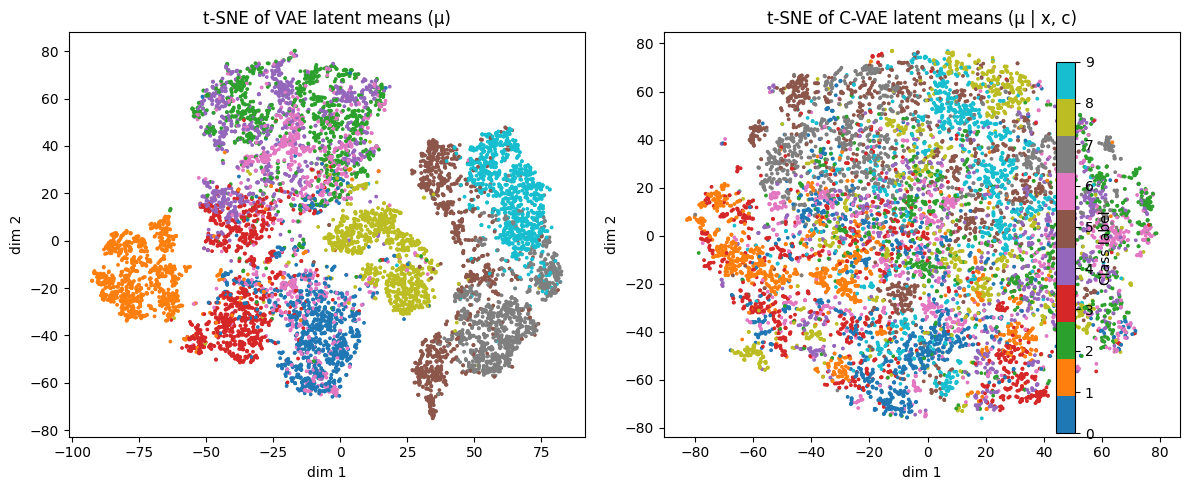

In [11]:
# ---------------------------------------------------
# t-SNE on mu (separately for VAE and C-VAE)
# ---------------------------------------------------
tsne = TSNE(
    n_components=2,
    random_state=42,
)
mu2d_vae = tsne.fit_transform(all_mu_vae)

# For a fair comparison, make a new TSNE instance for cVAE
tsne_c = TSNE(
    n_components=2,
    random_state=42,
)
mu2d_cvae = tsne_c.fit_transform(all_mu_cvae)

# ---------------------------------------------------
# Plot and save figures
# ---------------------------------------------------
plt.figure(figsize=(12, 5))

# VAE
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(mu2d_vae[:, 0], mu2d_vae[:, 1],
                       c=all_labels, s=3, cmap="tab10")
plt.title("t-SNE of VAE latent means (μ)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# C-VAE
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(mu2d_cvae[:, 0], mu2d_cvae[:, 1],
                       c=all_labels, s=3, cmap="tab10")
plt.title("t-SNE of C-VAE latent means (μ | x, c)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Common legend
cbar = plt.colorbar(scatter2, ax=plt.gcf().axes, fraction=0.02, pad=0.04)
cbar.set_label("Class label")

plt.tight_layout()
plt.savefig("tsne_vae_vs_cvae_fashionmnist.png", dpi=300)
plt.show()


## 3.3 Answer:

To compare the latent representations learned by the VAE and C-VAE, I passed all Fashion-MNIST test samples through each encoder and collected the posterior means 𝜇. I then applied t-SNE to project the 20-dimensional latent means into a 2-dimensional manifold and colored the points by class label. The resulting visualizations show clear and consistent differences between the two models.

VAE manifold (left figure).
The vanilla VAE produces a latent space where the data points form distinct, well-separated clusters, each corresponding to a different Fashion-MNIST class. Classes such as sneakers, boots, pullovers, and coats occupy their own regions. This separation occurs because the VAE has no access to the class label. Therefore, in order to reconstruct the input effectively, the encoder is forced to encode class-related information into the latent variable 𝑧. As a result, class identity becomes one of the dominant organizing factors of the latent space, leading to a structured and interpretable clustering pattern.

C-VAE manifold (right figure).
In contrast, the latent space learned by the C-VAE is much more entangled. The clusters almost completely overlap, and no clear class-dependent structure appears. This is expected because the decoder receives the class label 𝑐 explicitly, so the latent variable 𝑧 no longer needs to encode information about the object category. Instead, 𝑧 only captures residual variations within each class (e.g., style, orientation, thickness), while the class identity is handled separately by the conditioning variable. This reduces the pressure on the encoder to organize data by class, and the resulting latent manifold appears more “mixed” and dispersed.

Hypothesis.
The difference arises because the VAE must use 𝑧 to encode all information relevant to reconstructing 𝑥, including class identity. The C-VAE, however, offloads class information to the conditioning variable 𝑐, allowing 𝑧 to focus on intra-class variations. Consequently, the VAE forms class-separable clusters, whereas the C-VAE forms a more overlapping latent distribution.